### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import locale

from collections import defaultdict
import matplotlib.pyplot as plt; plt.rcdefaults()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn import metrics

import statsmodels.api as sm

import graphviz
import gmaps

### Functions

In [2]:
def Diff(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 

def nested_dd():
    return defaultdict(nested_dd)

def Diff(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif

def getLatLngByZip(zip,df):
    temp=df[df['zip_code'] == zip]
    temp=temp[['lat','lng']].drop_duplicates()
    return temp.values.tolist()

def rmse(predictions,actual):
    return np.sqrt(((prediction-actual)**2).mean())

### Load and View Data

In [3]:
assess_df = pd.read_csv('data/assessments.csv')
# Need to set dtype because several columns have mixed data types, setting them all to strings
opa_df= pd.read_csv('data/opa_properties_public.csv',dtype={'assessment_date': str,'book_and_page':str, 'cross_reference':str,
                                                      'other_building':str, 'sewer':str, 'unfinished':str, 'unit':str, 
                                                      'utility':str,'year_built':str, 'zip_code':str})

In [4]:
print(assess_df.info(), "\n")
print(opa_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280495 entries, 0 to 4280494
Data columns (total 7 columns):
parcel_number       float64
year                int64
market_value        float64
taxable_land        float64
taxable_building    float64
exempt_land         float64
exempt_building     float64
dtypes: float64(6), int64(1)
memory usage: 228.6 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581298 entries, 0 to 581297
Data columns (total 77 columns):
number_of_rooms              581287 non-null float64
assessment_date              146 non-null object
beginning_point              570162 non-null object
book_and_page                578466 non-null object
building_code                581296 non-null object
building_code_description    581296 non-null object
category_code                581296 non-null float64
category_code_description    581296 non-null object
census_tract                 581298 non-null float64
central_air                  283461 non-null object
cros

In [5]:
assess_df.sample(n=10)

,parcel_number,year,market_value,taxable_land,taxable_building,exempt_land,exempt_building
2346211,582058600.0,2017,194500.0,58350.0,106150.0,0.0,30000.0
1777317,11440900.0,2015,173600.0,11928.0,161672.0,0.0,0.0
1273005,622389500.0,2014,83600.0,15235.0,68365.0,0.0,0.0
585677,223225800.0,2017,251400.0,0.0,0.0,37710.0,213690.0
3500233,151306000.0,2016,412000.0,65431.0,346569.0,0.0,0.0
242660,663088600.0,2015,181000.0,48906.0,132094.0,0.0,0.0
4076023,583010315.0,2019,327000.0,93195.0,193805.0,0.0,40000.0
3901504,364028200.0,2019,77100.0,15100.0,62000.0,0.0,0.0
1713769,581095800.0,2014,324000.0,281130.0,42870.0,0.0,0.0
1685392,582397400.0,2020,260600.0,78180.0,182420.0,0.0,0.0


In [6]:
opa_df.sample(n=10)

,number_of_rooms,assessment_date,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,...,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,objectid,lat,lng
511634,0.0,NaN,19' N OXFORD ST,0157496,U50,ROW CONV/APT 3 STY MASON,2.0,Multi Family,731.0,NaN,...,NaN,NaN,I,1915,Y,191213202,RM1,498324689,39.977860,-75.161655
383191,0.0,NaN,100' E LORETTO AVE,0623936,B10,DET W/GAR 1 STY MASONRY,1.0,Single Family,720.0,NaN,...,NaN,NaN,I,1940,NaN,191522614,RSA3,498195034,40.065132,-75.054700
186805,4.0,NaN,107' N OF COLUMBIA,0000000,O30,ROW 2 STY MASONRY,1.0,Single Family,930.0,NaN,...,NaN,NaN,I,1925,NaN,191212811,RSA5,498004692,39.981675,-75.177893
136101,6.0,NaN,"114' 1/2""SE HORROCK",2973791,Q30,ROW W/DET GAR 2 STY MAS,1.0,Single Family,130.0,NaN,...,NaN,NaN,I,1945,Y,191243136,RM1,497954614,40.019070,-75.089720
7179,6.0,NaN,298' W OF 9TH ST,2852457,O30,ROW 2 STY MASONRY,1.0,Single Family,881.0,Y,...,NaN,NaN,I,1920,NaN,191481112,RSA5,497817523,39.928163,-75.161406
251760,6.0,NaN,59' S WOLF,1069235,O30,ROW 2 STY MASONRY,1.0,Single Family,160.0,NaN,...,NaN,NaN,I,1940,Y,191483702,RSA5,498065346,39.920456,-75.161201
301484,6.0,NaN,"208'1 1/8"" N.",1644816,O30,ROW 2 STY MASONRY,1.0,Single Family,410.0,N,...,NaN,NaN,I,1942,Y,191204529,RSA5,498112758,40.018136,-75.117477
361267,6.0,NaN,"320'8 1/2"" E OF",0063031,K30,S/D W/B GAR 2 STY MASONRY,1.0,Single Family,131.0,Y,...,NaN,NaN,I,1950,Y,191500000,RSA3,498170460,40.074023,-75.175792
315147,4.0,NaN,"122 1"" N VENANGO ST",0463313,O30,ROW 2 STY MASONRY,1.0,Single Family,610.0,N,...,NaN,NaN,I,1946,Y,191345519,RSA5,498120333,39.991527,-75.094660
538339,0.0,NaN,SEC CRANSTON RD,1695976,590,RES CONDO 5+ STY MASONRY,1.0,Single Family,230.0,Y,...,000017O,NaN,I,1960,Y,191312054,RM1,498350370,39.998782,-75.208691


In [7]:
opa_df.describe()

,number_of_rooms,category_code,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,...,sale_price,state_code,street_code,taxable_building,taxable_land,total_area,total_livable_area,objectid,lat,lng
count,581287.000000,581296.000000,581298.000000,5.812940e+05,5.812380e+05,5.812380e+05,555381.000000,581276.000000,5.812940e+05,581276.000000,...,5.812980e+05,581264.000000,581298.000000,5.812380e+05,5.812380e+05,5.812940e+05,5.812870e+05,5.812980e+05,581171.000000,581171.000000
mean,3.765641,1.609507,463.700641,1.108392e+02,7.476410e+04,1.629839e+04,3.740045,0.031802,1.098852e+03,0.349196,...,2.969122e+05,1514.381453,54188.622355,1.471248e+05,5.279799e+04,5.039855e+03,2.250229e+03,4.980996e+08,39.999830,-75.143500
std,3.105311,1.435636,288.771231,4.269818e+03,1.808741e+06,8.067065e+05,1.015864,0.235121,5.842447e+05,0.934259,...,1.121295e+07,1341.414954,24564.201119,1.608646e+06,4.269669e+05,2.965323e+05,1.649796e+04,1.678064e+05,0.050866,0.065903
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,1001.000000,11020.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.978088e+08,39.875131,-75.274389
25%,0.000000,1.000000,212.000000,5.700000e+01,0.000000e+00,0.000000e+00,4.000000,0.000000,1.500000e+01,0.000000,...,1.000000e+00,1001.000000,33120.000000,2.999100e+04,1.122000e+04,8.823700e+02,1.024000e+03,4.979543e+08,39.957732,-75.182658
50%,6.000000,1.000000,440.000000,7.700000e+01,0.000000e+00,0.000000e+00,4.000000,0.000000,1.600000e+01,0.000000,...,3.800000e+04,1001.000000,54840.000000,7.633000e+04,2.175650e+04,1.280000e+03,1.230000e+03,4.980996e+08,39.996515,-75.155170
75%,6.000000,1.000000,722.000000,1.000000e+02,4.000000e+04,0.000000e+00,4.000000,0.000000,2.041000e+01,1.000000,...,1.285000e+05,1001.000000,76760.000000,1.355600e+05,4.560000e+04,2.050410e+03,1.586000e+03,4.982449e+08,40.039884,-75.104737
max,89.000000,6.000000,982.000000,1.829520e+06,4.304176e+08,3.418426e+08,7.000000,10.000000,4.320260e+08,97.000000,...,9.487291e+08,9904.000000,89790.000000,3.048985e+08,7.411128e+07,2.076941e+08,2.500000e+06,4.983903e+08,40.137705,-74.958190


### Transform DataFrames

In [8]:
#count null values
assess_df.isnull().sum()

parcel_number       207903
year                     0
market_value             0
taxable_land             0
taxable_building         0
exempt_land              0
exempt_building          0
dtype: int64

In [9]:
# Removing any rows that have NULL values in the parcel_number column
assess_df=assess_df[~(assess_df['parcel_number'].isnull())]
opa_df=opa_df[~(opa_df['parcel_number'].isnull())]

In [10]:
print(assess_df.isnull().sum(),"\n")
print(opa_df['parcel_number'].isnull().sum())

parcel_number       0
year                0
market_value        0
taxable_land        0
taxable_building    0
exempt_land         0
exempt_building     0
dtype: int64 

0


In [11]:
#Add exempt_total column
assess_df['exempt_total'] = assess_df['exempt_building'] + assess_df['exempt_land']

In [12]:
assess_df_merged = pd.merge(assess_df, opa_df[['building_code','building_code_description','category_code','category_code_description',
                                               'year_built','lat','lng','homestead_exemption','number_of_bathrooms','number_of_bedrooms',
                                               'owner_1','owner_2','sale_date','sale_price','total_livable_area','zoning', 'parcel_number']]
                            ,on = 'parcel_number')

In [13]:
# Taking columns needed from assessments.csv
df1 = assess_df[['parcel_number','year','exempt_total']]
# Taking columns needed from opa_properties_public.csv
df2 = opa_df[['parcel_number','lat','lng','zip_code']]

In [14]:
# Merge dataframes into 1
df=pd.merge(df1, df2, on='parcel_number')
# Removing any rows that have NaN values in the lat or lng column
df=df[~(df['lat'].isnull())]
df=df[~(df['lng'].isnull())]
# just get first 5 of zipcode
df['zip_code']=df['zip_code'].str.extract('([0-9]{5})', expand=True)
df['zip_code'].fillna('1', inplace=True)

In [15]:
# Creating 2 dataframes, one that has the 10 year abatements, and one that does not
#40k is the homestead abatement
df_a=df[df['exempt_total'] > 40000]
df_n=df[df['exempt_total'] <= 40000]

In [16]:
#create bool mask for different abatements
assess_df_merged['homestead_exemption'] = ((assess_df_merged['category_code'] == 1) & 
                                    ((assess_df_merged['year'] <= 2018) & (assess_df_merged['exempt_building'] == 30000) |
                                    (assess_df_merged['year'] >= 2019) & (assess_df_merged['exempt_building'] == 40000)))
assess_df_merged['abatement10'] = ((assess_df_merged['year'] <= 2018) & (assess_df_merged['exempt_building'] > 30000) |
                                    (assess_df_merged['year'] >= 2019) & (assess_df_merged['exempt_building'] > 40000))

### Group By

In [17]:
grouped_property = assess_df_merged.groupby(['year'])

#Average assessed property value per year
avg_mv = grouped_property.mean()['market_value']
#Median assessed property value per year
med_mv = grouped_property.median()['market_value']

#Percentage of homestead and 10 year abated properties
hm = grouped_property.mean()['homestead_exemption']
ab = grouped_property.mean()['abatement10']

#count of properties per year
count = grouped_property.count()['parcel_number']

In [18]:
years = avg_mv.keys()

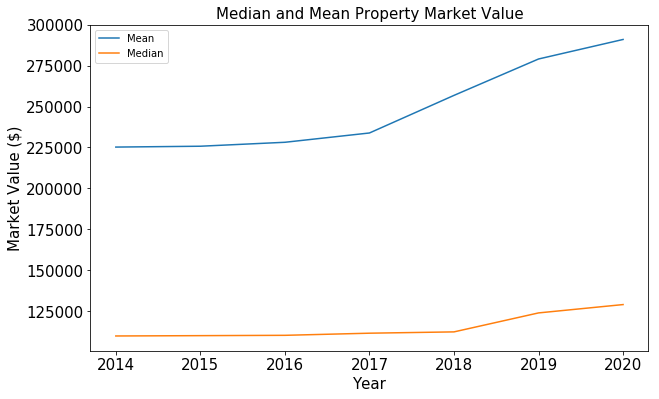

In [19]:
## set the figure dimensions
line_fig = plt.figure(figsize = (10, 6))
    
## make a line plot
_  = plt.plot(years, avg_mv, label = "Mean")
_  = plt.plot(years, med_mv, label = "Median")

## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Median and Mean Property Market Value", fontsize = 15)

## Set the y-label
_ = plt.ylabel("Market Value ($)", fontsize = 15)

## Set the x-label
_ = plt.xlabel("Year", fontsize = 15)

## Set Legend
_ = plt.legend(loc='upper left')

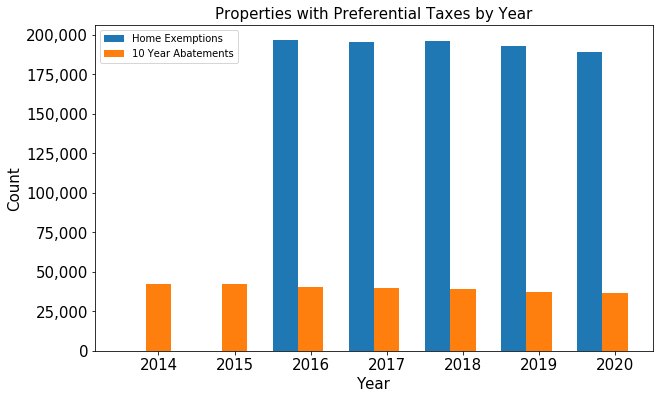

In [20]:
#Calculate optimal width
width = np.min(np.diff(years))/3

## set the figure dimensions
bar_fig = plt.figure(figsize = (10, 6))
ax = bar_fig.add_subplot(111)
    
## make a line plot
_ = ax.bar(years-width, hm*count, width, label = "Home Exemptions")
_ = ax.bar(years, ab*count, width, label = "10 Year Abatements")
_ = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Properties with Preferential Taxes by Year", fontsize = 15)

## Set the y-label
_ = plt.ylabel("Count", fontsize = 15)

## Set the x-label
_ = plt.xlabel("Year", fontsize = 15)

## Set Legend
_ = plt.legend(loc='upper left')

The Homestead exemption was passed by City Council in 2013 with implementation beginning in 2014 at $30,000. Data is missing for these properties in 2014 and 2015.

In [21]:
grouped_property_ccd = assess_df_merged.groupby(['category_code_description'])
count_ccd = grouped_property_ccd.count()['abatement10']
mean_ccd = grouped_property_ccd.mean()['abatement10']

In [22]:
ccd_table = pd.DataFrame({"COUNT PROPERTY":count_ccd,
                   "COUNT ABATED PROPERTY":mean_ccd*count_ccd})
ccd_table['PERCENTAGE'] = (ccd_table['COUNT ABATED PROPERTY']/ccd_table['COUNT PROPERTY'])*100
ccd_table = ccd_table.sort_values(by='COUNT PROPERTY', ascending = True)
ccd_table

,COUNT PROPERTY,COUNT ABATED PROPERTY,PERCENTAGE
category_code_description,,,
Industrial,30835,1626.0,5.273228
Commercial,97764,27657.0,28.289554
Mixed Use,100854,5560.0,5.512920
Multi Family,295096,23360.0,7.916068
Vacant Land,309393,978.0,0.316103
Single Family,3220669,218381.0,6.780610


There are 978 properties with a `category_code_description` of **Vacant Land** with a 10 year tax abatement. This is interesting because abatements are applicable to building improvements and not empty lots. These properties abatements should be reviewed by city officials, or this may be a case of bad data.

### Example of Abated Home

In [23]:
#Aviad's home
#example of a property with a 10 year tax abatement
assess_df.loc[assess_df['parcel_number'] == 888154334].sort_values('year')

,parcel_number,year,market_value,taxable_land,taxable_building,exempt_land,exempt_building,exempt_total
1110360,888154334.0,2014,0.0,0.0,0.0,0.0,0.0,0.0
1110359,888154334.0,2015,0.0,0.0,0.0,0.0,0.0,0.0
1110358,888154334.0,2016,0.0,0.0,0.0,0.0,0.0,0.0
1110357,888154334.0,2017,265500.0,39825.0,0.0,0.0,225675.0,225675.0
1110356,888154334.0,2018,265500.0,39825.0,0.0,0.0,225675.0,225675.0
4228933,888154334.0,2019,265500.0,39825.0,0.0,0.0,225675.0,225675.0
2252993,888154334.0,2020,265500.0,39825.0,0.0,0.0,225675.0,225675.0


In [24]:
#Aviad's home
#example of a property with a 10 year tax abatement
opa_df.loc[opa_df['parcel_number'] == 888154334]

,number_of_rooms,assessment_date,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,...,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,objectid,lat,lng
537764,0.0,NaN,SEC OF 18TH ST,3198301,571,RES CONDO 4 STY MAS+OTH,1.0,Single Family,520.0,Y,...,000000B,A,I,2015,NaN,191302816,RM1,498351383,39.967815,-75.16665


### Map abated homes on a map

In [25]:
with open('apikey.txt') as f:
    gmap_api_key = f.readline()
    f.close
    
gmaps.configure(api_key = gmap_api_key)

### Heatmap of homestead exemptions

All Philadelphian property owners who use their property as their primary residence are eligable for the Homestead Exemption. Hence we see high density of properties with this exemption throughout the city.

![Homestead Abatements 1](maps/Heat_Maps/Heat_Map_Homestead_1.png)

![Homestead Abatements 1](maps/Heat_Maps/Heat_Map_Homestead_2.png)

In [26]:
#homestead exemption in 2020 is $45k, however data shows $40k as this was the original proposed amount. 
#City counsel increased amount after data was published. 
#Confrimed with Sharon from revenue department that the data is stale.

home_expt = opa_df[['homestead_exemption','lat','lng']].loc[opa_df['homestead_exemption'] == 40000]
home_expt['lng'] = home_expt['lng'].round(4)
home_expt['lat'] = home_expt['lat'].round(4)
grouped_homestead = home_expt.groupby(['lat','lng'])
a = grouped_homestead.count()

In [27]:
locations = a.index.values
weights = a['homestead_exemption'].values

In [28]:
#Centered on City Hall
fig = gmaps.figure(center = (39.9524, -75.1636), zoom_level=11, map_type = 'HYBRID')
fig.add_layer(gmaps.heatmap_layer(locations, weights = weights, max_intensity = 100, point_radius = 5))
fig

Figure(layout=FigureLayout(height='420px'))

### Heatmap of 10 year tax abatement

The ten year tax abatement "encourages new construction or rehabilitation of properties with the exemption of all or part of the value of the improvement for a set number of years. Abatements help revitalize communities, retain residents, attract home- and business-owners to the city of Philadelphia, and reduce development costs for commercial and residential projects." The maps below show high concentration of abated properties in areas of the city where building and therefore gentrification is occuring at rapid pace: Fishtown, Kensignton, Brewerytown, Point Breeze, Graduate Hospital, Queen's Village.

![10 Year Abatements 1](maps/Heat_Maps/Heat_Map_10yr_1.png)

![10 Year Abatements 1](maps/Heat_Maps/Heat_Map_10yr_2.png)

In [29]:
ten_expt = opa_df[['exempt_building','homestead_exemption','lat','lng']].loc[opa_df['exempt_building'] > 0]
ten_expt = ten_expt[['exempt_building','lat','lng']].loc[ten_expt['exempt_building'] != ten_expt['homestead_exemption']]
ten_expt['lng'] = ten_expt['lng'].round(4)
ten_expt['lat'] = ten_expt['lat'].round(4)
grouped_ten = ten_expt.groupby(['lat','lng'])
b = grouped_ten.count()

In [30]:
locations = b.index.values
weights = b['exempt_building'].values

In [31]:
#Centered on City Hall
fig = gmaps.figure(center = (39.9524, -75.1636), zoom_level=11, map_type = 'HYBRID')
fig.add_layer(gmaps.heatmap_layer(locations, weights = weights, max_intensity = 100, point_radius = 5))
fig

Figure(layout=FigureLayout(height='420px'))

### Slider to show where new construction occuring in Philadelphia

The 10 year tax abatement was enacted in 1997 to spur development in the city. The slider can be used to identify areas of the city and neighborhoods that have gone through development phases. The photos below are the new builds in 2017 and 2018, respectively. We can see in 2017-18 certain neighborhoods, Brewerytown, Fishtown, Kensignton are seeing new properties being built. While West Philly and Center City are not exepriencing the same building activity.

![Properties Build 2017](maps/Heat_Maps/Heat_Map_Slider_2017.png)
![Properties Build 2018](maps/Heat_Maps/Heat_Map_Slider_2018.png)

In [32]:
age_df = opa_df[['year_built','lat','lng']]
age_df['year_built'] = pd.to_numeric(age_df["year_built"],errors='coerce')
#remove nulls
age_df = age_df.dropna()

#remove values below 1980 and above 2018
#1997 year of 10 year abatement enacted
age_df = age_df.loc[(age_df['year_built'] >= 1980) & (age_df['year_built'] <= 2019)]
age_df['lng'] = age_df['lng'].round(4)
age_df['lat'] = age_df['lat'].round(4)


C:\Users\areuve200\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Code borrowed from https://jupyter-gmaps.readthedocs.io/en/latest/app_tutorial.html

In [33]:
from IPython.display import display
import ipywidgets as widgets

class PropertyExplorer(object):
    """
    The user uses the slider to choose a year. This renders
    a heatmap of properties built in that year.
    """

    def __init__(self, df):
        self._df = df
        self._heatmap = None
        self._slider = None
        initial_year = min(self._df['year_built'])

        title_widget = widgets.HTML(
            '<center><h3>Heatmap of properties built in Philadelphia, by year</h3></center>'
        )

        map_figure = self._render_map(initial_year)
        controls = self._render_controls(initial_year)
        self._container = widgets.VBox([title_widget, controls, map_figure])

    def render(self):
        display(self._container)

    def _on_year_change(self, change):
        year = self._slider.value
        self._heatmap.locations = self._locations_for_year(year)
        self._total_box.value = self._total_properties_text_for_year(year)
        return self._container

    def _render_map(self, initial_year):
        fig = gmaps.figure(map_type='HYBRID')
        self._heatmap = gmaps.heatmap_layer(
            self._locations_for_year(initial_year),
            max_intensity=100,
            point_radius=8
        )
        fig.add_layer(self._heatmap)
        return fig

    def _render_controls(self, initial_year):
        self._slider = widgets.IntSlider(
            value=initial_year,
            min=min(self._df['year_built']),
            max=max(self._df['year_built']),
            description='Year',
            continuous_update=False
        )
        self._total_box = widgets.Label(
            value=self._total_properties_text_for_year(initial_year)
        )
        self._slider.observe(self._on_year_change, names='value')
        controls = widgets.HBox(
            [self._slider, self._total_box],
            layout={'justify_content': 'space-between'}
        )
        return controls

    def _locations_for_year(self, year):
        return self._df[self._df['year_built'] == year][['lat', 'lng']]

    def _total_properties_for_year(self, year):
        return int(self._df[self._df['year_built'] == year]['year_built'].count())

    def _total_properties_text_for_year(self, year):
        return '{} Properties Built'.format(self._total_properties_for_year(year))


PropertyExplorer(age_df[['year_built','lat','lng']]).render()

### Machine Learning

#### Multiple Linear Regression

Creating an multiple linear regression model to predict market value of residential real estate. Decided to limit the scope to residential for efficiency and for the possibility of better results. Further had to do some pre-processing to remove `NA` values as this method is unable to handle these values. Looked at residuals and the mean squared error (rmse) to assess the model performance with additional variables.

In [34]:
opa_df_ols = opa_df[['number_of_bathrooms',
                     'number_of_bedrooms',
                     'total_livable_area',
                     'market_value',
                     'total_area',
                     'depth',
                     'number_of_rooms']].loc[opa_df['category_code'] == 1]
opa_df_ols = opa_df_ols.dropna()
X = opa_df_ols[['number_of_bathrooms','number_of_bedrooms','total_livable_area','total_area','depth','number_of_rooms']]
X = sm.add_constant(X)
y = opa_df_ols['market_value']

C:\Users\areuve200\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
# Create the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
# Check to see if the datasets split correctly.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323020, 7) (323020,)
(138438, 7) (138438,)


In [36]:
# Build a linear model on training data
model_m = sm.OLS(y_train, X_train).fit()
model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4985.
Date:                Sat, 07 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:09:22   Log-Likelihood:            -4.6029e+06
No. Observations:              323020   AIC:                         9.206e+06
Df Residuals:                  323013   BIC:                         9.206e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.628e+04   2125.833    -12.364      0.000   -3.04e+04   -2.21e+04
number_of_bathrooms  8.848e+04   1534.528     57.659      0.000    8.55e+04    9.15e+04
number_of_bedrooms  -2.806e+04   1043.022    -26.903      0.000   -3.01e+04    -2.6e+04
total_livable_area    181.8569      1.359    133.801      0.000     179.193     184.521
total_area             -2.9529      0.196    -15.049      0.000      -3.337      -2.568
depth                 -11.6944      2.213     -5.285      0.000     -16.031      -7.358
number_of_rooms     -1.038e+04    486.634    -21.324      0.000   -1.13e+04   -9423.347
===============================================================================
Omnibus:                  1776345.092   Durbin-Watson:                    2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   176460146288792.250
Skew:                         304.573   Prob(JB):                          0.00
Kurtosis:                  114503.685   Cond. No.                      1.41e+04
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
# Predict values of `market_value` using the test data.
actual = y_test
prediction = model_m.predict(X_test)
residuals = actual - prediction

property_result = pd.concat([actual.rename('actual'),prediction.rename('predicted'),residuals.rename('residuals')], axis = 1)
property_result.head()

,actual,predicted,residuals
395734,203800.0,225826.477081,-22026.477081
454233,77900.0,119090.296257,-41190.296257
536694,282600.0,178476.398417,104123.601583
177270,69300.0,94519.734843,-25219.734843
321412,88700.0,99194.449776,-10494.449776


In [38]:
print(rmse(prediction,actual))

158868.1017592656


This portion of code below would remove outliers, however, after a few hours of running it does not return results. I got it to run on a data set of significanlty less recods, ~19k. This is a system limitation and ideally we would remove outliers, re-run the model and then predict the `market_value` based on the best OLS model.

```python
test_m = model_m.outlier_test()
test_final_m = test_m[test_m['bonf(p)'] < 0.05]

# Drop outliers from both X and y train sets.
X_train_no_outliers = X_train.drop(test_final_m.index)
y_train_no_outliers = y_train.drop(test_final_m.index)

model_m_no_outliers =sm.OLS(y_train_no_outliers, X_train_no_outliers).fit()
prediction = model_m_no_outliers.predict(X_test)

```